In [ ]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
import numpy as np
import json
import csv

In [ ]:
print(1)

In [ ]:
print(device)

In [ ]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
# desired_res = (32, 32, 32)

In [ ]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.train()  # Set the model to training mode

# Define hyperparameters for fine-tuning
fine_tune_hyperparams = {
    'learning_rate': 1e-6,  # Small learning rate
    'batch_size': 16,       # Smaller batch size for limited data
    'num_epochs': 50,
    'factor': 0.5,          # LR decay factor
    'patience': 3           # Patience for LR scheduler
}
print(desired_res)

In [ ]:
foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}
for i, knot in enumerate(knots):
    print(knot, ':  ', i)

In [ ]:

folders = [
    # '/home/dt169/ML_knots/DATA/all_flowers10_5.4/',
    'D:\\Codes\\Python\\Duke\\Knots_flowers_turbulence_ML_paper3\\knots_propagation\\paper_final_experiment_Danilo_4foils\\all_flowers20_005',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_experiment_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')




In [ ]:
from sklearn.model_selection import train_test_split

# Convert data lists into numpy arrays
X_np = np.array(X_list)
y_np = np.array(Y_list)

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Convert to PyTorch tensors
X_torch_train = torch.tensor(X_train).reshape(-1, 1, *desired_res).float()
X_torch_test = torch.tensor(X_test).reshape(-1, 1, *desired_res).float()
y_torch_train = torch.tensor(y_train)
y_torch_test = torch.tensor(y_test)
print()
# One-hot encode the labels
y_train_dots = F.one_hot(y_torch_train.long(), num_classes=num_classes).float()
y_test_dots = F.one_hot(y_torch_test.long(), num_classes=num_classes).float()

# Create TensorDatasets for training and testing
train_dataset_dots = TensorDataset(X_torch_train, y_train_dots)
test_dataset_dots = TensorDataset(X_torch_test, y_test_dots)

# Create DataLoaders for training and testing
train_loader_dots = DataLoader(train_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)

print(f"Training set size: {len(train_dataset_dots)}")
print(f"Testing set size: {len(test_dataset_dots)}")

In [ ]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

In [ ]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

In [ ]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in train_loader_dots:
        inputs = batch[0].to(device)
        # print(torch.max(batch[1], 1)[1])
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
print(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_train_dots, 1)
print(true_class_labels)
# print(torch.max(y_test_dots, 1)[1])
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

In [ ]:

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=fine_tune_hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=fine_tune_hyperparams['factor'],
                              patience=fine_tune_hyperparams['patience'], verbose=True)

# Mixed precision training setup
scaler = GradScaler()

# Fine-tuning loop
train_losses = []
for epoch in trange(fine_tune_hyperparams['num_epochs'], desc="Fine-tuning Progress"):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader_dots:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():  # Enable mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backpropagation with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader_dots)
    train_losses.append(avg_loss)

    # Step the LR scheduler
    scheduler.step(avg_loss)

    print(f"Epoch {epoch + 1}/{fine_tune_hyperparams['num_epochs']}, Loss: {avg_loss:.4f}")

# Save the fine-tuned model
fine_tuned_model_path = "fine_tuned_classifier_4foil_3d.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': fine_tune_hyperparams,
    'stages': stages,
    'pooling_configs': pooling_configs,
    'desired_res': desired_res,
    'num_classes': num_classes
}, fine_tuned_model_path)

print(f"Fine-tuned model saved to {fine_tuned_model_path}")

92
92


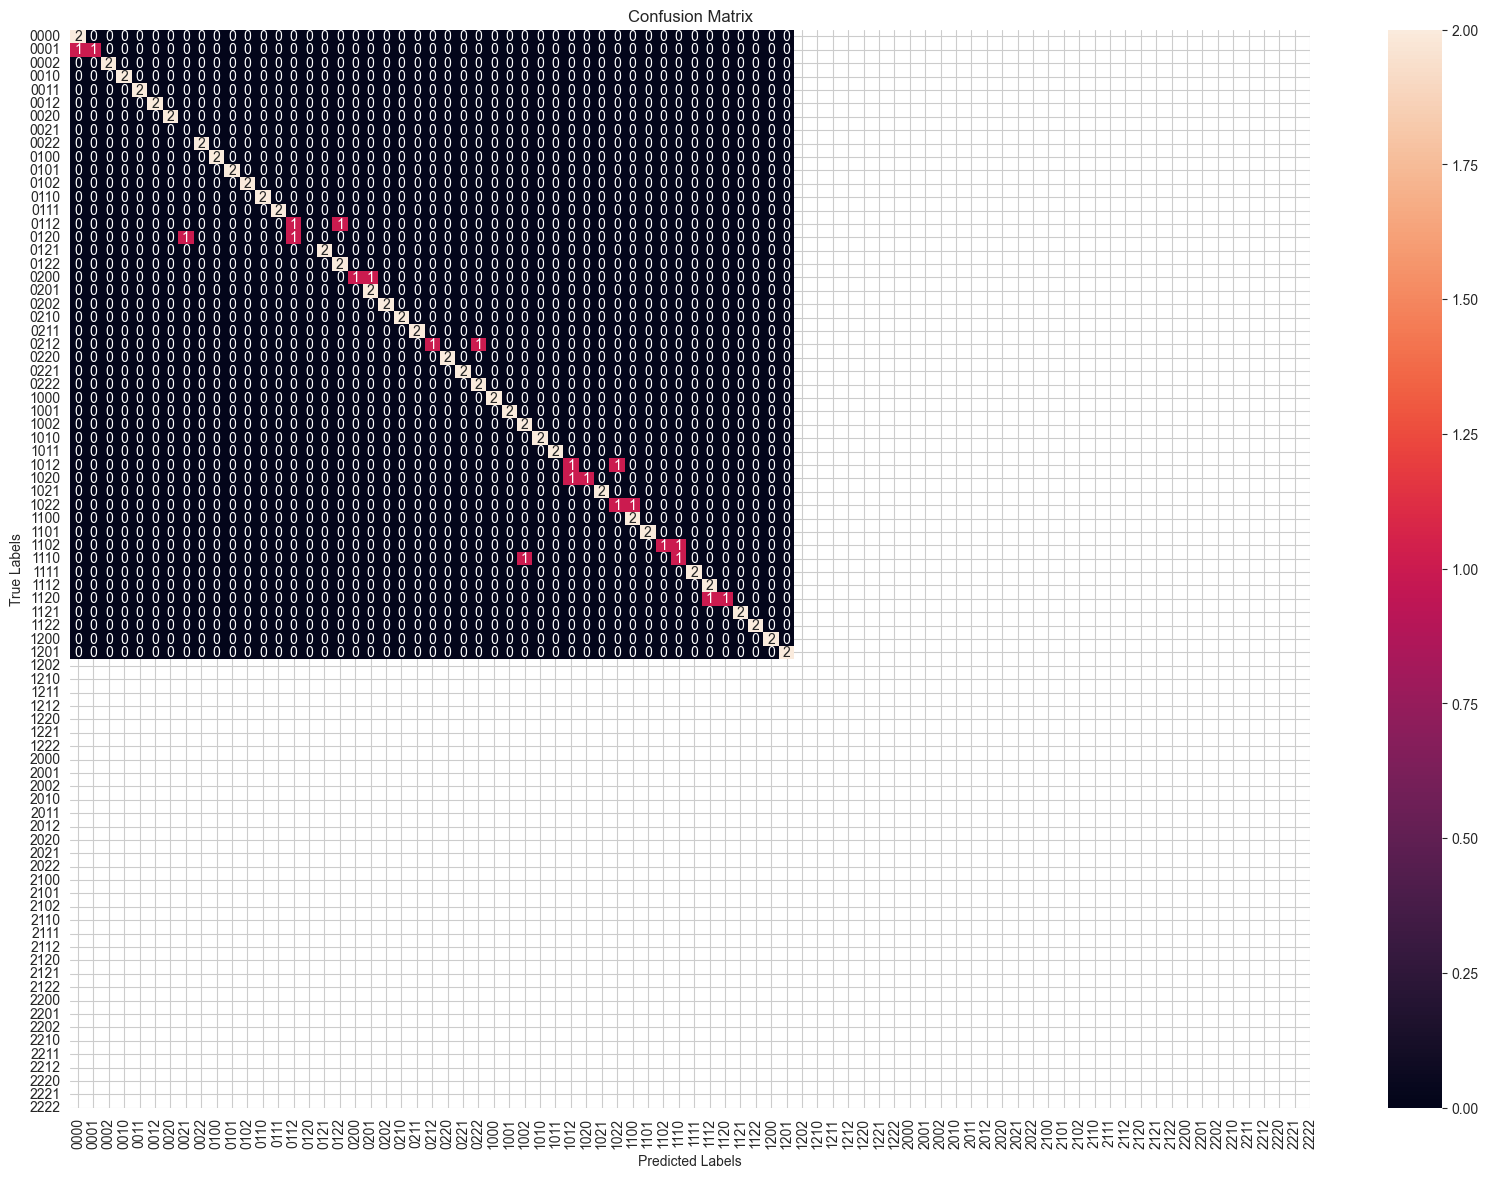

0.8695652173913043


In [107]:
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
# print(predicted_labels)
print(len(predicted_labels))
# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test_dots, 1)
print(len(true_class_labels))
# print(true_class_labels)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.9320652173913043
